# Import

In [94]:
# Classic
import os
import pandas as pd
import re
import time


# Natural Language Processing librarie
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Deep learning framework
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Machine learning librarie
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Word2vec : Tokenizer
import gensim



# Chargement des données

#### Présentation des données

Les données viennent d'un challenge Kaggle : https://www.kaggle.com/kazanova/sentiment140/data.
Ce sont 1 600 000 tweets extrait avec l'api twitter.
Ce sont des données qui sont labélisées :
* 0 : commentaire négatif
* 2 : neutre
* 4 : commentaire positif


#### Attributs :

target: la note (0, 2 ou 4)

ids: l'id du tweet ( 2087)

date: la date du tweet (Sat May 16 23:58:44 UTC 2009)

flag: la requête (lyx).NO_QUERY si pas de requête

user: l'utilisateur qui a tweeté (robotickilldozr)

text: contenu du tweet (Lyx is cool)



In [95]:
data = pd.read_csv("Data/data.csv", header=None, encoding='ISO-8859-1', usecols=[0,5])
data = data.rename(columns={0:'Polarity', 5:'Text'})

In [96]:
data.head()

,Polarity,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [97]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

# Data Processing

In [99]:
#Expression régulière pour enlever les liens, les # etc..
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.Text = data.Text.apply(lambda x: preprocess(x))

In [100]:
TRAIN_SIZE = 0.8

#A partir du set de données on va créer un set d'entrainement et un set de test
df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [101]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

#Chargement de word2Vec (un dictionnaire de mot avec des polarités)
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [102]:
#On récupère tous les mots de tous les tweets
documents = [_Text.split() for _Text in df_train.Text]

In [103]:
#On associe à ces mots les polarités du w2v
w2v_model.build_vocab(documents)

In [104]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [105]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 5min 4s


(263122662, 295270528)

In [106]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 20 s


In [107]:
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Text), maxlen=SEQUENCE_LENGTH)

In [108]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

df_train.Polarity = df_train.Polarity.apply(lambda x: decode_sentiment(x))
df_test.Polarity = df_test.Polarity.apply(lambda x: decode_sentiment(x))


labels = df_train.Polarity.unique().tolist()
labels.append("NEUTRAL")
labels

C:\Users\Anthime\anaconda3\envs\Data_Science\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [109]:
encoder = LabelEncoder()
encoder.fit(df_train.Polarity.tolist())

y_train = encoder.transform(df_train.Polarity.tolist())
y_test = encoder.transform(df_test.Polarity.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)
x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [110]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [111]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Modèle

In [33]:

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [35]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [36]:
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 1661s 1ms/step - loss: 0.5004 - accuracy: 0.7531 - val_loss: 0.4596 - val_accuracy: 0.7817
Epoch 2/8


C:\Users\Anthime\anaconda3\envs\Data_Science\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 2405s 2ms/step - loss: 0.4838 - accuracy: 0.7640 - val_loss: 0.4552 - val_accuracy: 0.7840
Epoch 3/8
1152000/1152000 [==============================] - 1646s 1ms/step - loss: 0.4803 - accuracy: 0.7664 - val_loss: 0.4537 - val_accuracy: 0.7848
Epoch 4/8
1152000/1152000 [==============================] - 1654s 1ms/step - loss: 0.4791 - accuracy: 0.7674 - val_loss: 0.4579 - val_accuracy: 0.7828
Epoch 5/8
1152000/1152000 [==============================] - 1649s 1ms/step - loss: 0.4782 - accuracy: 0.7684 - val_loss: 0.4537 - val_accuracy: 0.7850
Epoch 6/8
1152000/1152000 [==============================] - 1666s 1ms/step - loss: 0.4761 - accuracy: 0.7688 - val_loss: 0.4536 - val_accuracy: 0.7853
Epoch 7/8
1152000/1152000 [==============================] - 17203s 15ms/step - loss: 0.4740 - accuracy: 0.7703 - val_loss: 0.4513 - val_accuracy: 0.7858
Epoch 8/8
1152000/1152000 [==============================] - 2286s 2ms/step - loss: 0.4721 - acc

In [37]:
#Sauvegarder les poids de notre réseau de neuronne pour ne pas avoir à le réentrainer
model.save('sentiment_analysis_model_2.h5')

In [38]:
model.save_weights("weights.best_accuracy.hdf5")

In [112]:
model.load_weights("weights.best_accuracy.hdf5")

# Evaluation du modèle

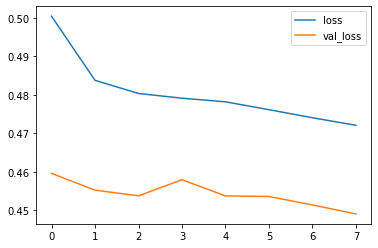

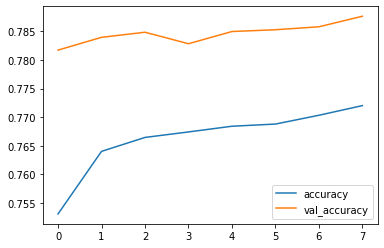

In [113]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
,
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [114]:
#Prédiction sur le jeu de test
y_pred = model.predict(x_test, batch_size=256)

In [115]:
#Résultats
score = model.evaluate(x_test, y_test, batch_size=256, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.448500031542778
Test accuracy: 0.7873906493186951


In [117]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [118]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9814226627349854,
 'elapsed_time': 0.05932021141052246}

In [25]:
import tensorflow as tf

assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

In [26]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15580072946297889092
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1416432435
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2834440187728685803
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1
